<a href="https://colab.research.google.com/github/BYK82/AIFFEL/blob/main/%5BE_14%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 14-14.프로젝트: CIFAR-10 이미지 생성하기


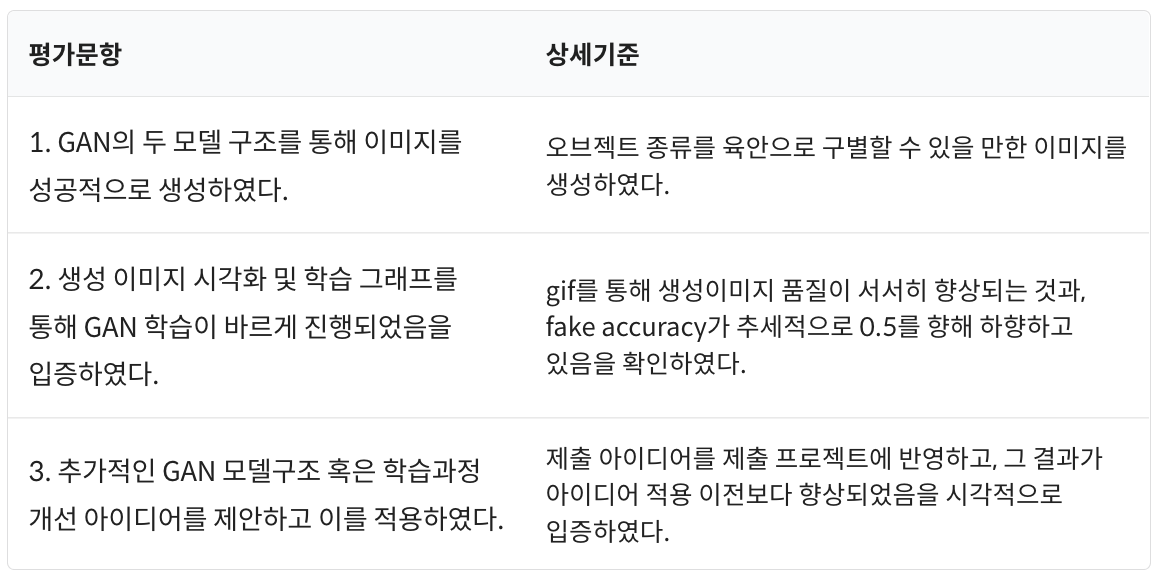
GAN을 학습하는 과정은 보기보다 까다롭습니다. 모델 구조, learning_rate, 파라미터 초기화, 생성자와 판별자의 경쟁 관계, 데이터의 특성 등 고려해야 할 것이 참 많습니다.

이번에는 앞에서 배운 FASHION-MNIST 데이터 생성용 DCGAN 모델구조를 이용해서 CIFAR-10 데이터를 생성하는 모델을 직접 만들어 봅시다.
모델 구현 및 학습의 전과정의 흐름은 거의 비슷하겠지만, 아래와 같이 몇 가지 달라지는 점이 있습니다.

- 이미지 데이터의 shape가 (28, 28, 1)에서 (32, 32, 3)으로 변경됩니다. 생성자, 판별자 모델의 입출력 shape 및 모델 구조에 영향이 있습니다.
- 이미지가 단색의 grayscale에서 RGB 3채널의 컬러이미지로 변경됩니다. 시각화 과정에서 고려할 점이 있습니다.
- 입력데이터 전체 차원이 3~4배 증가하면서, 학습이 진행되는 양상이 다소 달라집니다.

In [ ]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams

print("tensorflow", tf.__version__)

tensorflow 2.8.2


## Step 1. 작업환경 구성하기

하위 폴더 만들기

## Step 2. 데이터셋 구성하기

In [ ]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

170508288/170498071 [==============================] - 11s 0us/step


(50000, 32, 32, 3)

- 학습에 사용할 train_x의 이미지를 -1, 1로 정규화합니다.
- 로드한 학습 데이터를 시각화를 통해 확인해 봅시다.
- tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하여 미니배치 데이터셋을 구성해 봅시다.

In [ ]:
#max값과 min값 출력
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [ ]:
#학습에 사용할 train_x 이미지를 -1에서 1사이 값으로 정규화
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [ ]:
train_x.shape

(50000, 32, 32, 3)

In [ ]:
#이미지 데이터 shape 32,32,3
train_x = train_x.reshape(train_x.shape[0], 32, 32, 3).astype('float32')
train_x.shape

(50000, 32, 32, 3)

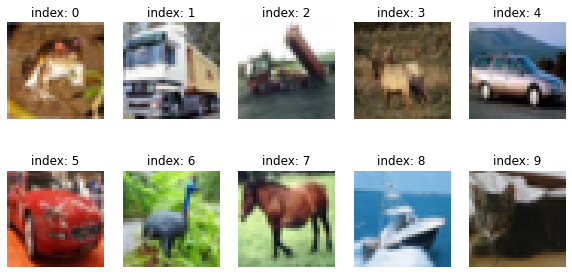

In [ ]:
plt.figure(figsize=(10, 5))

for i in range(10):  #10개 이미지 확인
    plt.subplot(2, 5, i+1)
    plt.imshow((train_x[i] + 1) / 2.0)
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

In [ ]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [ ]:
#tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하여 미니배치 데이터셋 구성
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
# 학습시간이 오래 걸릴때 한종류의 데이터만 추출해 진행하기
# def load_data(label=None):
#     (train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()
#     if label:
#         df = pd.DataFrame(list(zip(train_x, train_y)), columns=['image', 'label']) 
#         df = df[df['label']==label]
#         train_x = np.array([i for i in list(df['image'])])
#         df = pd.DataFrame(list(zip(test_x, test_y)), columns =['image', 'label']) 
#         df = df[df['label']==label]
#         test_x = np.array([i for i in list(df['image'])])
#     return train_x, test_x

## Step 3. 생성자 모델 구현하기

- (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성해 봅시다.
- noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성해 봅시다.
- 생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인해 봅시다.


In [ ]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [ ]:
generator = make_generator_model() #generator변수로 생성모델 생성

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1638400   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 128)        5

In [ ]:
#랜덤 노이즈를 입력하여 방금 구현한 생성자로 랜덤 이미지를 생성
noise = tf.random.normal([1, 100])


In [ ]:
generated_image = generator(noise, training=False)  #가우시안 분포에서 뽑아낸 랜덤 벡터로 이루어진 노이즈 벡터 생성
generated_image.shape

TensorShape([1, 32, 32, 3])

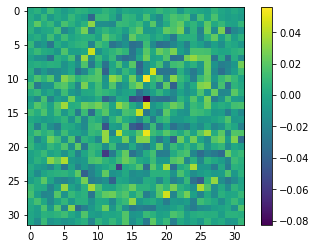

In [ ]:
#시각화
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

## Step 4. 판별자 모델 구현하기 

- (32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수를 작성해 봅시다.
- 위 STEP 2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인해 봅시다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()  #discriminator 변수로 판별모델 생성

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)             

In [ ]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00263501]], dtype=float32)>

## Step 5. 손실함수와 최적화 함수 구현하기

- 생성자와 판별자의 손실함수(loss)를 구현해 봅시다.

- 판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현해 봅시다.

- 생성자와 판별자를 최적화하는 optimizer를 정의합니다.

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
#real_output:기존에 있던 Real Image를 구분자에 입력시켜서 판별된 값, 즉 D(real_image)
#fake_output:생성자가 생성한 Fake Image를 구분자에 입력시켜서 판별된 값, 즉 D(fake_image)

#generator_loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output) 

In [ ]:
#discriminator_loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
#discriminator accuracy
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [ ]:
#최적화 함수(optimizer)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)  #Adam 최적화 기법 활용
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
noise_dim = 100
num_examples_to_generate = 16  # 생성자가 생성한 샘플 16개

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

## Step 6. 훈련과정 상세 기능 구현하기

- 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 구현해 봅시다.
- 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수를 구현해 봅시다.
- 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 draw_train_history() 함수를 구현해 봅시다.
- training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정해 봅시다.

In [ ]:
@tf.function  #이 데코레이터는 우리가 직접 session을 열어서 학습했다가, 학습이 완료되면 다시 닫아주는 등의 번거로운 과정을 내부적으로 처리해서 더욱 편리하게 학습시킬 수 있게 해준다.
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [ ]:
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('/content/drive/MyDrive/0.AIFFEL/LMS node/Exp 14/cifar10/training_history/train_history_{:04d}.png')
    plt.show()

In [ ]:
#정기적으로 모델을 저장하기 위한 checkpoint
checkpoint_dir = '/content/drive/MyDrive/0.AIFFEL/LMS node/Exp 14/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Step 7. 학습 과정 진행하기

- 위 STEP 5에서 구현한 기능들을 활용하여 최소 50 epoch만큼의 모델 학습을 진행해 봅시다.
- 학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현해 봅시다.
- 학습 과정을 담은 샘플 이미지, gif 파일, 학습 진행 그래프 이미지를 함께 제출합니다.


(참고)  학습 과정 중 학습 epoch를 추가 진행해야 하거나, 학습한 모델을 활용하여 이미지를 생성할 필요가 생깁니다. 그럴 때마다 모델 학습을 처음부터 다시 진행한다면 시간 낭비가 될 것입니다.
우리는 위에서 checkpoint 모듈을 이용해 모델을 저장해 둔 바 있습니다. 이를 이용해 학습해 둔 모델을 로드하면 모델 재학습이 필요 없이 이런 작업을 진행할 수 있습니다.
아래는 checkpoint 모듈을 활용하여 모델을 로드하는 예시입니다.

In [ ]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)  #지금까지 한 단계를 학습
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)  # 샘플 이미지를 생성하고 저장
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)  # 모델 저장

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)  # 학습 과정을 시각화

In [ ]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
def generate_and_save_images(model, epoch, it, sample_seeds):
    
    predictions = model(sample_seeds, training=False)
    
    fig = plt.figure(figsize=(12, 12))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(np.array(predictions[i] * 127.5 + 127.5).astype('uint8'))
        plt.axis('off')
        
    plt.savefig('/content/drive/MyDrive/0.AIFFEL/LMS node/Exp 14/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png')

    plt.show()

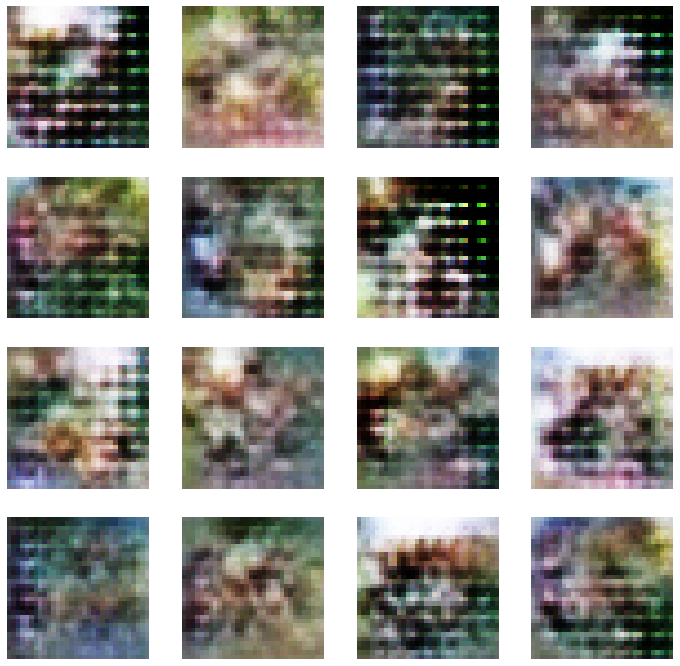

Time for training : 508 sec


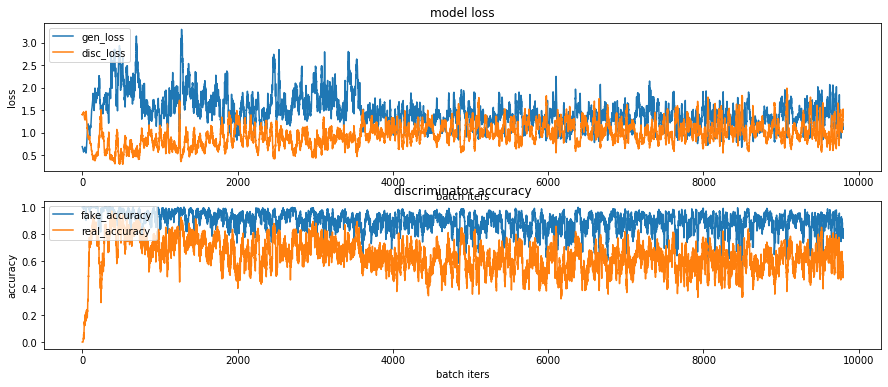

CPU times: user 8min 45s, sys: 12.7 s, total: 8min 58s
Wall time: 8min 29s


In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

In [ ]:
#학습과정 시각화하기
anim_file = '/content/drive/MyDrive/0.AIFFEL/LMS node/Exp 14/cifar10/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('/content/drive/MyDrive/0.AIFFEL/LMS node/Exp 14/cifar10/generated_samples/sample*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l '/content/drive/MyDrive/0.AIFFEL/LMS node/Exp 14/cifar10/cifar10_dcgan.gif'


-rw------- 1 root root 523647 Jun 22 01:28 '/content/drive/MyDrive/0.AIFFEL/LMS node/Exp 14/cifar10/cifar10_dcgan.gif'


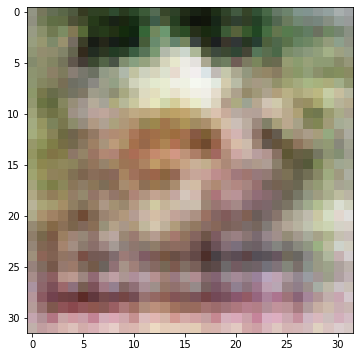

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/0.AIFFEL/LMS node/Exp 14/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그

## Step 8. (optional) GAN 훈련 과정 개선하기

- STEP 6을 진행하면서 생성된 샘플 이미지, 학습 과정 그래프 등을 통해 이전 훈련 과정의 문제점을 분석해 봅시다.
- 모델구조 또는 학습 과정을 개선한 내역과 그 결과(샘플 이미지, 학습 과정 그래프 포함)를 함께 제출합니다.

https://github.com/soumith/ganhacks

https://towardsdatascience.com/10-lessons-i-learned-training-generative-adversarial-networks-gans-for-a-year-c9071159628

https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/

https://proceedings.neurips.cc/paper/2016/file/8a3363abe792db2d8761d6403605aeb7-Paper.pdf

(1) Epochs = 200

In [ ]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [ ]:
save_every = 5
EPOCHS = 200

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

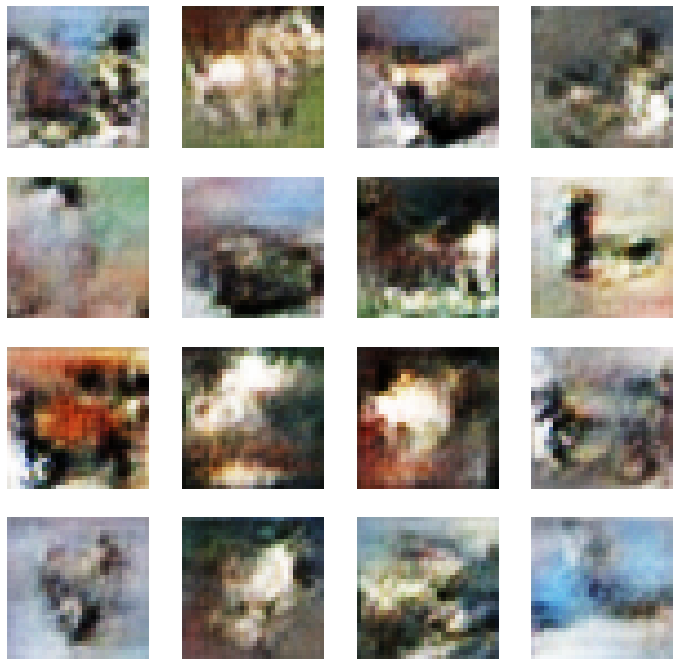

Time for training : 2106 sec


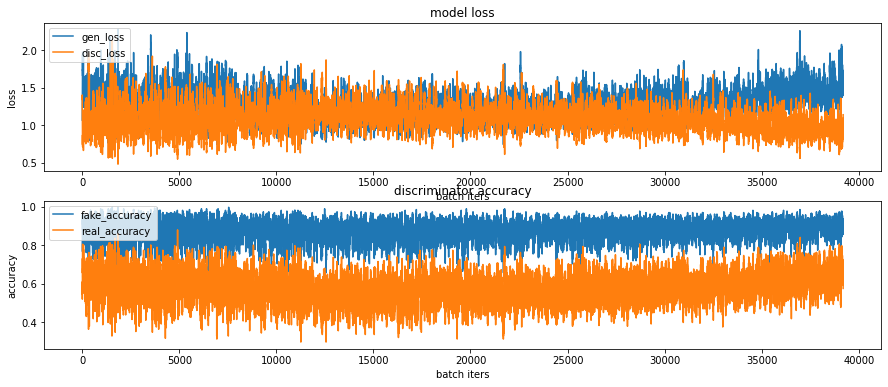

CPU times: user 36min 42s, sys: 45.7 s, total: 37min 27s
Wall time: 35min 8s


In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

In [ ]:
#시각화
anim_file = '/content/drive/MyDrive/0.AIFFEL/LMS node/Exp 14/cifar10/cifar10_dcgan1.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('/content/drive/MyDrive/0.AIFFEL/LMS node/Exp 14/cifar10/generated_samples/sample*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l '/content/drive/MyDrive/0.AIFFEL/LMS node/Exp 14/cifar10/cifar10_dcgan1.gif'


-rw------- 1 root root 499599 Jun 22 02:03 '/content/drive/MyDrive/0.AIFFEL/LMS node/Exp 14/cifar10/cifar10_dcgan1.gif'


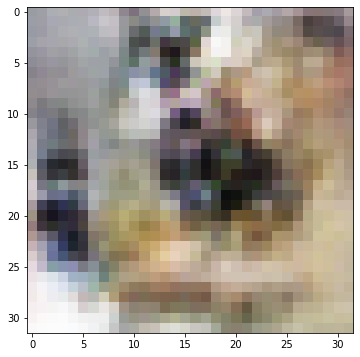

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/0.AIFFEL/LMS node/Exp 14/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그

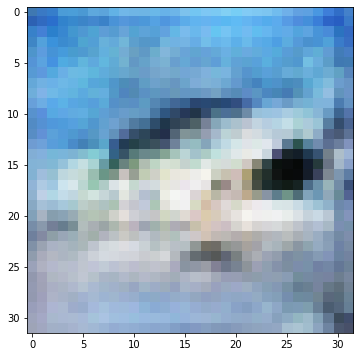

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/0.AIFFEL/LMS node/Exp 14/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

(2) Epochs = 1000
- 학습시 이미지가 흑백으로 보여 코드를 수정함

In [ ]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [ ]:
save_every = 5
EPOCHS = 500

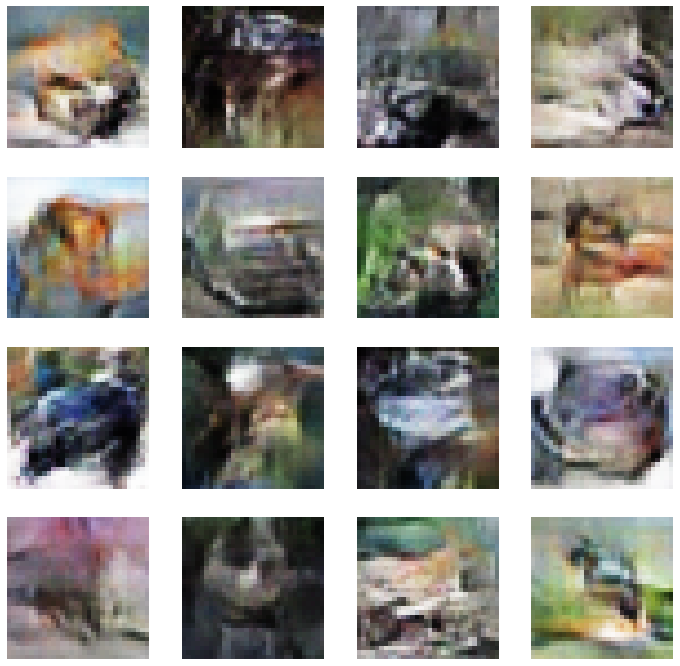

Time for training : 5711 sec


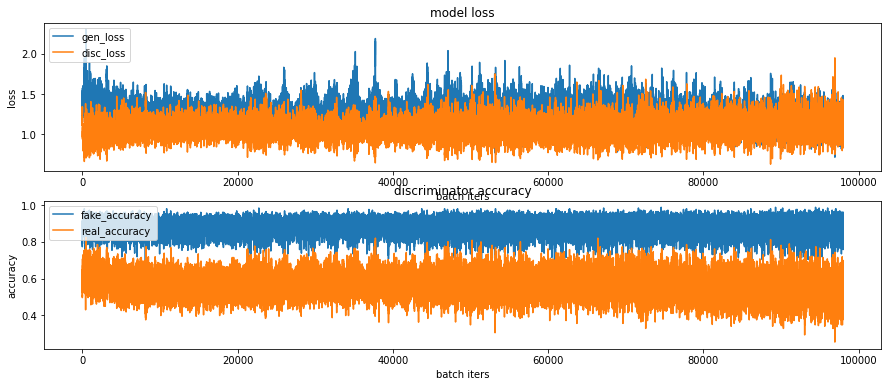

CPU times: user 1h 39min 14s, sys: 2min 7s, total: 1h 41min 22s
Wall time: 1h 35min 16s


In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

In [ ]:
#시각화
anim_file = '/content/drive/MyDrive/0.AIFFEL/LMS node/Exp 14/cifar10/cifar10_dcgan2.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('/content/drive/MyDrive/0.AIFFEL/LMS node/Exp 14/cifar10/generated_samples/sample*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l '/content/drive/MyDrive/0.AIFFEL/LMS node/Exp 14/cifar10/cifar10_dcgan2.gif'


-rw------- 1 root root 501901 Jun 22 03:38 '/content/drive/MyDrive/0.AIFFEL/LMS node/Exp 14/cifar10/cifar10_dcgan2.gif'


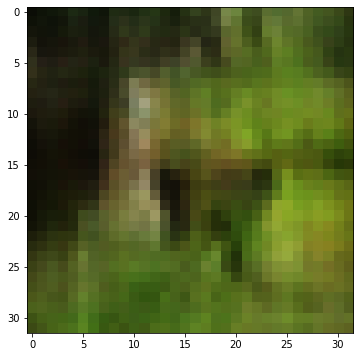

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/0.AIFFEL/LMS node/Exp 14/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

(3) Model 추가

In [ ]:
def make_generator_model_two():
    model = tf.keras.Sequential()

    model.add(layers.Dense(8 * 8 * 128, activation='relu', input_shape=(100,)))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))

    model.add(layers.Reshape((8, 8, 128)))

    model.add(layers.Conv2D(128, kernel_size=4, strides=1, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))

    model.add(layers.Conv2DTranspose(128, 4, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))

    model.add(layers.Conv2D(128, kernel_size=5, strides=1,padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))

    model.add(layers.Conv2DTranspose(128, 4, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))

    model.add(layers.Conv2D(128, kernel_size=5, strides=1, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))

    model.add(layers.Conv2D(3, kernel_size=5, strides=1, padding="same", activation='tanh'))

    return model

In [ ]:
generator_two = make_generator_model_two()

generator_two.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 8192)              827392    
                                                                 
 batch_normalization_3 (Batc  (None, 8192)             32768     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 8192)              0         
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 batch_normalization_4 (Batc  (None, 8, 8, 128)        512       
 hNormalization)                                      

In [ ]:
noise = tf.random.normal([1, 100])
generated_image = generator_two(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

In [ ]:
def make_discriminator_model_two():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(32, kernel_size=3, strides=2, input_shape=(32, 32, 3), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(64, kernel_size=3, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(256, kernel_size=3, strides=1, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [ ]:
discriminator_two = make_discriminator_model_two()

discriminator_two.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 16, 16, 32)        896       
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 16, 16, 32)        0         
                                                                 
 dropout_2 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 batch_normalization_9 (Batc  (None, 8, 8, 64)         256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 8, 8, 64)          0         
                                                      

In [ ]:
save_every = 5
EPOCHS = 500

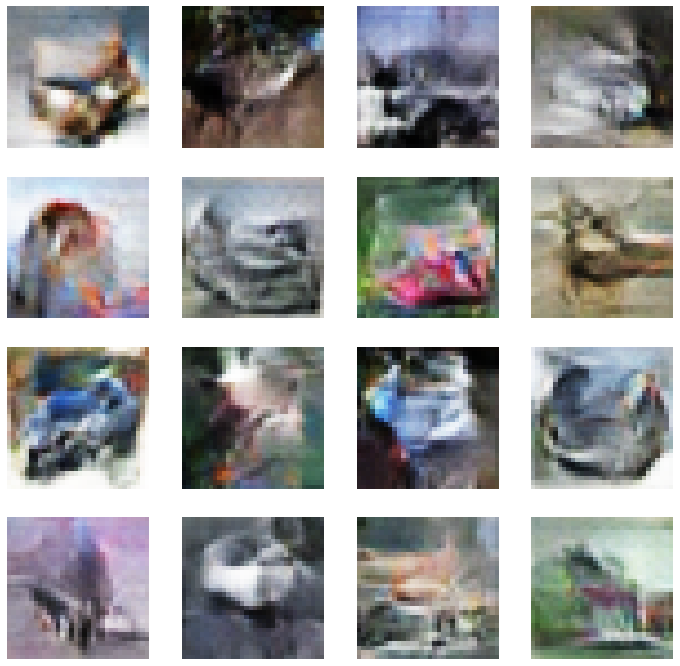

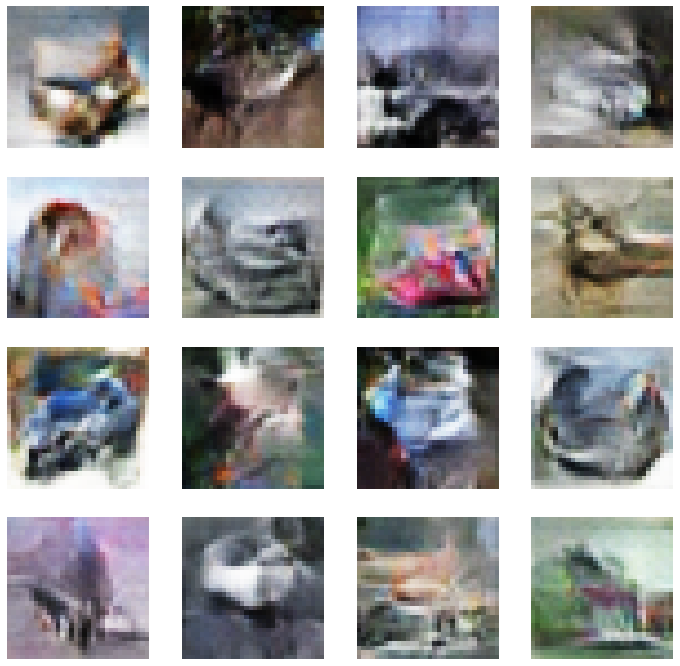

Time for training : 5694 sec
Time for training : 5694 sec


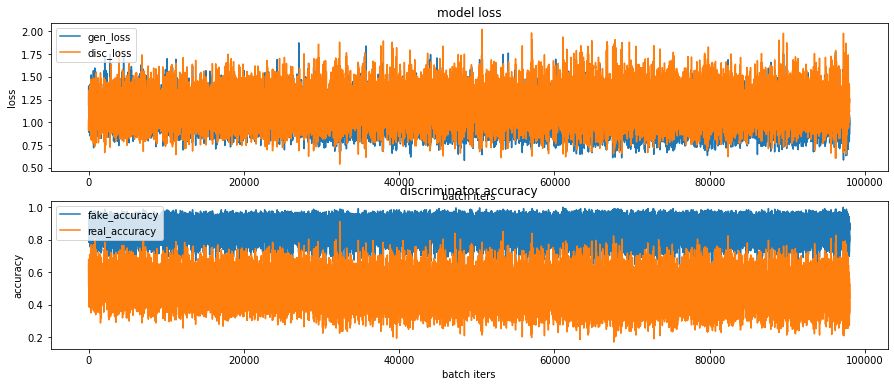

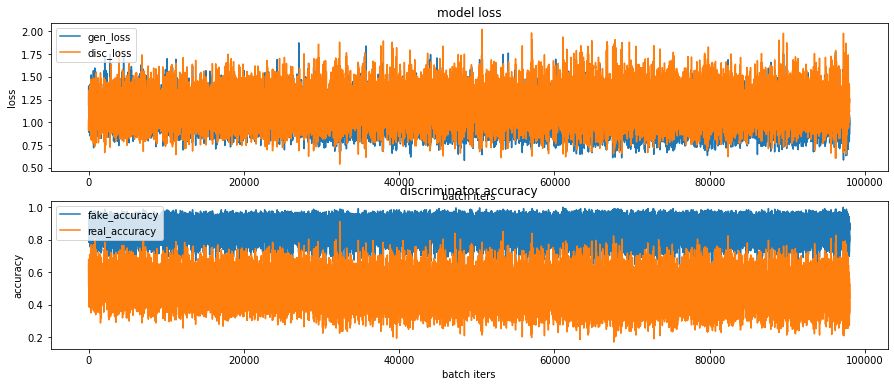

CPU times: user 1h 39min 13s, sys: 2min 4s, total: 1h 41min 17s
Wall time: 1h 34min 59s
CPU times: user 1h 39min 13s, sys: 2min 4s, total: 1h 41min 17s
Wall time: 1h 34min 59s


In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

In [ ]:
#시각화
anim_file = '/content/drive/MyDrive/0.AIFFEL/LMS node/Exp 14/cifar10/cifar10_dcgan3.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('/content/drive/MyDrive/0.AIFFEL/LMS node/Exp 14/cifar10/generated_samples/sample*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l '/content/drive/MyDrive/0.AIFFEL/LMS node/Exp 14/cifar10/cifar10_dcgan3.gif'


-rw------- 1 root root 497241 Jun 22 05:41 '/content/drive/MyDrive/0.AIFFEL/LMS node/Exp 14/cifar10/cifar10_dcgan3.gif'


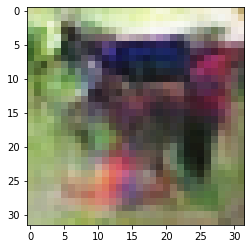

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/0.AIFFEL/LMS node/Exp 14/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

## 참고

- https://github.com/yenaryu/Project/blob/main/%5BE-10%5DCIFAR-10.ipynb

- https://panython.tistory.com/12

- https://gruuuuu.github.io/machine-learning/cifar10-cnn/

## 회고

- 이건 뭐지...? 라는 생각이 첫 느낌이었다. 갑자기 하늘에서 떨어진 것 같은 느낌의 모델이랄까... 앞의 노드들과 연결이 되지 않아서 많이 당황스러웠다. 고잉디퍼로 들어가기전에 많은 것들을 알려주고 싶어서인듯하지만 연결이 되지 않으니 당황스러움이 가득했다. 어찌해서 많은 복붙으로 이해는 안되지만 코드를 돌리는 것까지 성공했고 이것저것 바꿔서 시도도 해보았다. 하지만 사상누각의 느낌은 지울수가 없다. 고잉디퍼 들어가면 더 열심히 해야겠다는 생각만이 남았다. 이상태로라면 과연 시간을 들여서 배운 것이 무엇인지에 대한 의문만이 남지 않을까 우려된다. 

- 뭔지는 모르겠지만 epoch을 늘리고 모델을 더 쌓으니 처음보단 그림 비슷한게 나오긴 했다. 
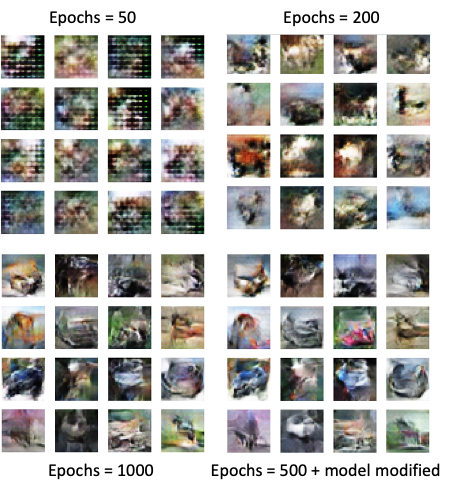

- 모델을 좀 더 이해해서 보완한다면 결과는 더 나아질 것으로 예상된다. epochs는 적당한 수 이상이면 되는 것 같다.
